# Generalisation

This notebook tests whether the MLP trained weights for the CLT transform generalise to other distributions.

As the weights matrices are asymmetric we expect that they shouldn't...the 'true function' should learn symmetric weights such that the NN retains permutation invariance.

## Plan

- Extract the weights trained on the uniform distribution in CLT_proper.ipynb or CLT_Fischer.ipynb
- Using the exact same NN architecture, evaluate on a different input distribution
- Use evaluation metric from my work reproducing Fisher results

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from scipy.stats import norm


# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Extract Weights

In [56]:
# Load the saved weights from the file
model_weights = torch.load('CLT_Fisher__221nobias_model_weights.pth')

# Dictionary to store extracted weight matrices
extracted_weights = {}
for name, weight in model_weights.items():
    if 'weight' in name:
        extracted_weights[name] = weight.detach().cpu().numpy()
weight_1 = extracted_weights['non_linear_activ.0.weight']
weight_2 = extracted_weights['non_linear_activ.2.weight']

# Display the extracted weights
print("Extracted Weights:\n")
for name, weight in extracted_weights.items():
    print(f"Name: {name}")
    print(f"Shape: {weight.shape}")
    print(weight)
    print("\n----------\n")

alpha = 0.5

Extracted Weights:

Name: non_linear_activ.0.weight
Shape: (2, 2)
[[ 0.7209409   0.72991323]
 [-0.9347847  -0.9197867 ]]

----------

Name: non_linear_activ.2.weight
Shape: (1, 2)
[[ 0.54737806 -0.33434257]]

----------



# New Input Distribution

Use an exponential

In [57]:
# Sample pairs of points from a centred 1D uniform distribution
def get_data_uniform(number):
    x = np.random.uniform(low=-0.5, high=0.5, size=(number, 2))
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

nu = 3
def get_data_exponential(number):
    x = np.random.exponential(scale=1/nu, size=(number, 2))  # sample from Exp(λ=1), numpy defines scale inversely
    decimated_x = np.sum(x, axis=1) / np.sqrt(2)               # same projection trick
    return x, decimated_x

a, b = 2, 5
def get_data_beta(number):
    """
    Samples pairs of points from a Beta(a, b) distribution,
    shifts them to be centered around 0 (optional),
    and returns the 2D samples and their projection.

    Parameters:
        number (int): Number of samples to generate.
        a (float): Alpha (shape) parameter of the Beta distribution.
        b (float): Beta (shape) parameter of the Beta distribution.

    Returns:
        x: np.ndarray of shape (number, 2)
        decimated_x: np.ndarray of shape (number,)
    """
    x = np.random.beta(a, b, size=(number, 2))       # Sample from Beta(a, b)
    # x = x - 0.5                                       # Shift to center around 0
    decimated_x = np.sum(x, axis=1) / np.sqrt(2)      # Project to 1D
    return x, decimated_x


class uniform_data(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_uniform(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.true_samples[idx], dtype=torch.float32)
        )

class exponential_data(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_exponential(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.true_samples[idx], dtype=torch.float32)
        )

class beta_data(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_beta(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.true_samples[idx], dtype=torch.float32)
        )


n_test = int(1e5)

uniform_samples = uniform_data(n_test)
uniform_loader = DataLoader(uniform_samples, batch_size=64, shuffle=False)

exp_samples = exponential_data(n_test)
exp_loader = DataLoader(exp_samples, batch_size=64, shuffle=False)

beta_samples = beta_data(n_test)
beta_loader = DataLoader(beta_samples, batch_size=64, shuffle=False)

## Checking Distribution

In [58]:

def cumulant_extraction(data):
    """
    Compute the first four cumulants for a 1D array.
    Parameters:
        data: np.ndarray of shape (N,)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    mean = np.mean(data)                          # κ1
    centered = data - mean

    var = np.mean(centered**2)                    # κ2
    third = np.mean(centered**3)                  # κ3
    fourth_raw = np.mean(centered**4)
    fourth = fourth_raw - 3 * var**2              # κ4

    return {
        'kappa1': mean,
        'kappa2': var,
        'kappa3': third,
        'kappa4': fourth
    }

def expected_cumulant_evolution(data):
    """Input: data is a dictionary of input cumulants
    This function scales each cumulant according to my Laplace transform of 2.3"""
    
    scaled_cumulants = {}
    for key, value in data.items():
        # Extract the cumulant order (k) from the key string 'kappa{k}'
        k = int(key[-1])
        
        # Calculate the scaling factor
        scaling_factor = 2 ** (1 - k / 2)
        
        # Scale the cumulant value
        scaled_cumulants[key] = value * scaling_factor
    
    return scaled_cumulants

def cumulant_extraction_multidim(data):
    """
    Compute the first four cumulants for a 2D array.
    Parameters:
        data: np.ndarray of shape (N, 2)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    N, d = data.shape
    
    # Mean vector (κ1)
    mean = np.mean(data, axis=0)  # Shape: (2,)
    
    # Centered data
    centered = data - mean  # Shape: (N, 2)
    
    # Covariance matrix (κ2)
    " Using einsum() to find the covariance is implicitly assuming that there is already some level of correlation"
    " Between the two dimensions. If the data is uncorrelated, this will yield a covariance matrix with off-diagonal elements close to zero."
    " But the data should be two independent columns initially, with a diagonal covariance - and correlations will emerge as you propagate them."
    # covariance = np.einsum('ni,nj->ij', centered, centered) / N  # Shape: (2, 2)
    covariance = np.diag(np.var(data, axis=0))  # Shape: (2, 2)
    
    # Third-order cumulant tensor (κ3)
    G3 = np.einsum('ni,nj,nk->ijk', centered, centered, centered) / N  # Shape: (2, 2, 2)
    
    # Fourth-order cumulant tensor (κ4)
    G4_raw = np.einsum('ni,nj,nk,nl->ijkl', centered, centered, centered, centered) / N  # Shape: (2, 2, 2, 2)
    
    # Applying the correction for the fourth cumulant
    G4 = G4_raw - 3 * np.einsum('ij,kl->ijkl', covariance, covariance)
    
    # Package the results in a dictionary
    cumulants = {
        'kappa1': torch.tensor(mean, dtype=torch.float32),                     # Shape: (2,)
        'kappa2': torch.tensor(covariance, dtype=torch.float32),               # Shape: (2, 2)
        'kappa3': torch.tensor(G3, dtype=torch.float32),                       # Shape: (2, 2, 2)
        'kappa4': torch.tensor(G4, dtype=torch.float32)                        # Shape: (2, 2, 2, 2)
    }
    
    return cumulants

def plot_histogram(data, title, bins=50, color='blue'):
    """
    Plots a histogram of the data.
    
    Parameters:
        data (array-like): The data to plot.
        title (str): Title of the plot.
        bins (int): Number of bins in the histogram.
        color (str): Color of the histogram.
    """
    plt.figure(figsize=(4, 3))
    plt.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# For the beta distribution:

def beta_cumulants(alpha, beta):
    """
    Compute the first four cumulants of a Beta(alpha, beta) distribution.

    Parameters:
        alpha (float): Shape parameter α
        beta (float): Shape parameter β

    Returns:
        dict: Dictionary containing the first four cumulants (kappa1 to kappa4)
    """
    x = alpha
    y = beta
    S = x + y
    S1 = S + 1
    S2 = S + 2
    S3 = S + 3

    # First cumulant (mean)
    kappa1 = x / S

    # Second cumulant (variance)
    kappa2 = (x * y) / (S**2 * S1)

    # Third cumulant
    kappa3 = (2 * x * y * (y - x)) / (S**3 * S1 * S2)

    # Fourth cumulant
    num = 6 * x * y * ((x - y)**2 * S1 - x * y * S2)
    den = S**4 * S1**2 * S2 * S3
    kappa4 = num / den

    return {
        'kappa1': kappa1,
        'kappa2': kappa2,
        'kappa3': kappa3,
        'kappa4': kappa4
    }


# Test Model

## Define model

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define quadratic activation function
alpha = 0.5
class QuadraticActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        return z + alpha*(z ** 2)

# Define model, L=1, N=10, sigma = 0.75
class oneDNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        " 1 linear layer, no nonlinearity, no bias "
        # self.non_linear_activ = nn.Sequential(nn.Linear(2,1, bias=False))

        " 1 hidden layer with a quadratic nonlinearity (so can reuse Fischer analysis directly):"
        self.non_linear_activ = nn.Sequential(
            nn.Linear(2, 2, bias=False),
            QuadraticActivation(),
            # nn.Tanh(), # This now won't get propagated correctly because the code I've got is set up for a quadratic nonlinearity
            nn.Linear(2, 1, bias=False)
        )

        " 2 hidden layers with a quadratic nonlinearity (so can reuse Fischer analysis directly):"
        # self.non_linear_activ = nn.Sequential(
        #     nn.Linear(2, 10, bias=False),
        #     QuadraticActivation(),
        #     nn.Linear(10, 10, bias=False),
        #     QuadraticActivation(),
        #     nn.Linear(10, 1, bias=False)
        # )
        self._initialize_weights()
    
    def forward(self, x):
        logits = self.non_linear_activ(x)
        return logits
    
    def _initialize_weights(self):
        for i, m in enumerate(self.non_linear_activ):
            if isinstance(m, nn.Linear):
                if i == 0:
                    nn.init.normal_(m.weight, mean=0, std=np.sqrt(0.75/2))
                else:
                    nn.init.normal_(m.weight, mean=0, std=np.sqrt(0.75/10))    
                # nn.init.normal_(m.bias, mean=0, std=np.sqrt(0.75))
                # nn.init.constant_(m.bias, 0)

Using cpu device


## Initialise with extracted weights

In [60]:
# Instantiate the model and move it to the appropriate device
model = oneDNetwork().to(device)

# Load the extracted weights into the model
with torch.no_grad():  # Avoid tracking gradients while loading weights
    model.non_linear_activ[0].weight.copy_(torch.tensor(weight_1))
    model.non_linear_activ[2].weight.copy_(torch.tensor(weight_2))

print("Model initialized with extracted weights.")


Model initialized with extracted weights.


## Test

### Exp Distribution

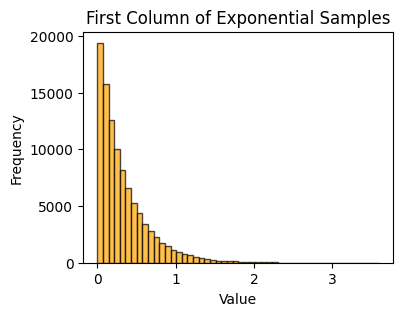

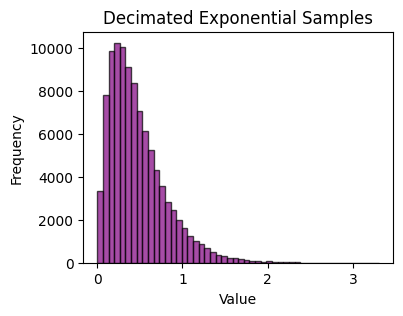

Expected Input Cumulants:
Mean: 0.3333333333333333, var: 0.1111111111111111, G3: 0.07407407407407407, G4: 0.07407407407407407

Initial Empirical Cumulants (first col):
kappa1: 0.33273122745762657
kappa2: 0.1103806855200021
kappa3: 0.07183252417893805
kappa4: 0.06751841170746864



Output Cumulants:

Laplace transform evolution on col 1:
kappa1: 0.4705530144956227
kappa2: 0.1103806855200021
kappa3: 0.05079326495667374
kappa4: 0.03375920585373432

Output Cumulants ( ground truth labels):
kappa1: 0.4711017528856627
kappa2: 0.1109905733782481
kappa3: 0.052217896905333266
kappa4: 0.036743310978747376
-------------------


Extracted Cumulants (raw network output):
kappa1: 0.471299946308136
kappa2: 0.11119506508111954
kappa3: 0.05247633159160614
kappa4: 0.03715161979198456





In [61]:
def collect_model_outputs(dataloader, model):
    """
    Collects all outputs from the model for the given dataloader and stacks them into a 1D numpy array.

    Parameters:
        dataloader (DataLoader): The DataLoader to iterate over.
        model (torch.nn.Module): The trained model whose outputs are to be collected.

    Returns:
        np.ndarray: A 1D NumPy array of all model outputs concatenated together.
    """
    model.eval()  # Switch to evaluation mode (no gradients tracked)
    all_outputs = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for X, _ in dataloader:
            X = X.to(device)
            outputs = model(X)
            all_outputs.append(outputs.squeeze().cpu().numpy())  # Ensure outputs are 1D and on CPU

    # Concatenate all outputs into a single 1D NumPy array of size (N,)
    all_outputs = np.concatenate(all_outputs, axis=0)

    return all_outputs


# Plot input/output for exp distribution

# raw_x, decimated_x = get_data_exponential(n_test)
# col1 = raw_x[:, 0]  # First column of the (N, 2) input array
# col2 = raw_x[:, 1]  # Second column of the (N, 2) input array
# plot_histogram(col1, title='First Column of Exponential Samples', color='orange') # Plot the first column of the (N, 2) input array
# plot_histogram(decimated_x, title='Decimated Exponential Samples', color='purple') # Plot the projected 1D output (decimated_x)

def get_columns(data):

    col1 = []
    col2 = []
    decimated_x = []
    for i in range(len(data)):
        x, y = data[i]
        col1.append(x[0].item())
        col2.append(x[1].item())
        decimated_x.append(y.item())

    col1 = np.array(col1)  # Shape: (n_train, )
    col2 = np.array(col2)  # Shape: (n_train, )
    decimated_x = np.array(decimated_x)  # Shape: (n_train, )

    return col1, col2, decimated_x


col1, col2, decimated_x = get_columns(exp_samples)

plot_histogram(col1, title='First Column of Exponential Samples', color='orange') # Plot the first column of the (N, 2) input array
plot_histogram(decimated_x, title='Decimated Exponential Samples', color='purple') # Plot the projected 1D output (decimated_x)


# Print cumulants to check

# Expected Input
print("Expected Input Cumulants:")
print(f"Mean: {1/nu}, var: {1/(nu**2)}, G3: {2/(nu**3)}, G4: {6/(nu**4)}")

# Input
def get_input_cumulants(data, first_col=True, sec_col=True, multidim=True):

    column1, column2, decimated_x = get_columns(data)

    if first_col:
        first_column = cumulant_extraction(column1)
        print("\nInitial Empirical Cumulants (first col):")
        for k, v in first_column.items():
            print(f"{k}: {v}")
    else:
        first_column = None

    if sec_col:
        second_column = cumulant_extraction(column2)
        print("\nInitial Empirical Cumulants (second col):")
        for k, v in second_column.items():
            print(f"{k}: {v}")
    else:
        second_column = None

    if multidim:
        x_c = data.samples
        inps = cumulant_extraction_multidim(x_c)
        print("\n Multivariate input cumulants:")
        for k, v in inps.items():
            print(f"{k}: shape = {v.shape}, value = {v}")
    else:
        inps = None

    
    return first_column, second_column, inps


in_cumulants_col1, in_cumulants_col2, input_cumulants = get_input_cumulants(exp_samples, first_col=True, sec_col=False, multidim=False)

# Output
print("\n\n\nOutput Cumulants:")
print(f"\nLaplace transform evolution on col 1:")
expected_cumulants = expected_cumulant_evolution(in_cumulants_col1)
for k, v in expected_cumulants.items():
    print(f"{k}: {v}")

out_cumulants = cumulant_extraction(decimated_x)
print("\nOutput Cumulants ( ground truth labels):")
for k, v in out_cumulants.items():
    print(f"{k}: {v}")
print("-------------------\n")


test_trained_outputs = collect_model_outputs(exp_loader, model)
out_cumulants_trained = cumulant_extraction(test_trained_outputs)
print("\nExtracted Cumulants (raw network output):")
for k, v in out_cumulants_trained.items():
    print(f"{k}: {v}")
print("\n\n")

### Beta Distribution

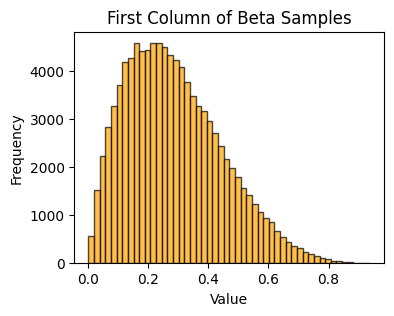

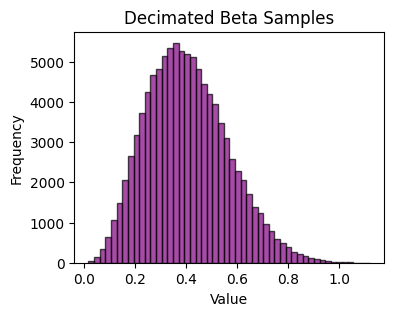


Expected Input Cumulants:
kappa1: 0.2857142857142857
kappa2: 0.025510204081632654
kappa3: 0.0024295432458697765
kappa4: -7.809246147438568e-05

Initial Empirical Cumulants (first col):
kappa1: 0.28551095441103097
kappa2: 0.02533156787903317
kappa3: 0.002348659243312915
kappa4: -8.853213147137664e-05

Initial Empirical Cumulants (second col):
kappa1: 0.2861896747124678
kappa2: 0.02563432680959492
kappa3: 0.00244451629585573
kappa4: -8.408718110178119e-05

 Multivariate input cumulants:
kappa1: shape = torch.Size([2]), value = tensor([0.2855, 0.2862])
kappa2: shape = torch.Size([2, 2]), value = tensor([[0.0253, 0.0000],
        [0.0000, 0.0256]])
kappa3: shape = torch.Size([2, 2, 2]), value = tensor([[[ 2.3487e-03,  2.9709e-06],
         [ 2.9709e-06, -3.8324e-06]],

        [[ 2.9709e-06, -3.8324e-06],
         [-3.8324e-06,  2.4445e-03]]])
kappa4: shape = torch.Size([2, 2, 2, 2]), value = tensor([[[[-8.8532e-05,  2.7907e-06],
          [ 2.7907e-06, -1.3004e-03]],

         [[ 2.7907e

In [62]:
col1 = []
col2 = []
decimated_x = []
for i in range(len(beta_samples)):
    x, y = beta_samples[i]
    col1.append(x[0].item())
    col2.append(x[1].item())
    decimated_x.append(y.item())

col1 = np.array(col1)  # Shape: (n_train, )
col2 = np.array(col2)  # Shape: (n_train, )
decimated_x = np.array(decimated_x)  # Shape: (n_train, )

plot_histogram(col1, title='First Column of Beta Samples', color='orange') # Plot the first column of the (N, 2) input array
plot_histogram(decimated_x, title='Decimated Beta Samples', color='purple') # Plot the projected 1D output (decimated_x)


# Print cumulants to check

# Expected Input
print("\nExpected Input Cumulants:")
beta_dist_cumulants = beta_cumulants(alpha=2.0, beta=5.0)
for k, v in beta_dist_cumulants.items():
    print(f"{k}: {v}")

# Input
in_cumulants_col1 = cumulant_extraction(col1)
print("\nInitial Empirical Cumulants (first col):")
for k, v in in_cumulants_col1.items():
    print(f"{k}: {v}")

in_cumulants_col2 = cumulant_extraction(col2)
print("\nInitial Empirical Cumulants (second col):")
for k, v in in_cumulants_col2.items():
    print(f"{k}: {v}")

x = beta_samples.samples
input_cumulants = cumulant_extraction_multidim(x)
print("\n Multivariate input cumulants:")
for k, v in input_cumulants.items():
    print(f"{k}: shape = {v.shape}, value = {v}")


# Output
print("\n\n\nOutput Cumulants:")
print(f"\nLaplace transform evolution on col 1:")
expected_cumulants = expected_cumulant_evolution(in_cumulants_col1)
for k, v in expected_cumulants.items():
    print(f"{k}: {v}")

out_cumulants = cumulant_extraction(decimated_x)
print("\nOutput Cumulants ( ground truth labels):")
for k, v in out_cumulants.items():
    print(f"{k}: {v}")
print("-------------------\n")


test_trained_outputs = collect_model_outputs(beta_loader, model)
out_cumulants_trained = cumulant_extraction(test_trained_outputs)
print("\nExtracted Cumulants (raw network output):")
for k, v in out_cumulants_trained.items():
    print(f"{k}: {v}")
print("\n\n")

# Testing RG Composition

Completely input cumulants:


Initial Empirical Cumulants (first col):
kappa1: 0.0005534907906870012
kappa2: 0.08323945596435758
kappa3: -3.6012314898021545e-05
kappa4: -0.008321867376416249


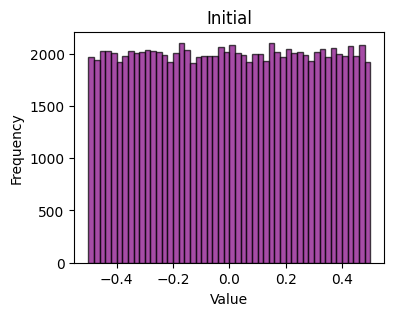


Now iterating...

Iteration 1:


Initial Empirical Cumulants (first col):
kappa1: 0.0006250728408404393
kappa2: 0.08287831367441446
kappa3: 7.700815746055461e-05
kappa4: -0.004071324992896943

Manually find cumulants after it1 (should be the same as the above block):
kappa1: 0.0006250728408404393
kappa2: 0.08287831367441446
kappa3: 7.700815746055461e-05
kappa4: -0.004071324992896943

Predictions:

Laplace transform evolution:
kappa1: 0.0008839864889876284
kappa2: 0.08287831367441446
kappa3: 5.445299034703959e-05
kappa4: -0.0020356624964484715

Output Cumulants (ground truth labels):
kappa1: 0.0008839865124240456
kappa2: 0.08301296845971033
kappa3: 3.574264388537683e-05
kappa4: -0.002032918321709303
-------------------




Iteration 2:


Initial Empirical Cumulants (first col):
kappa1: 0.0009304416845153264
kappa2: 0.08301474106416241
kappa3: 5.603850486921556e-05
kappa4: -0.0020323471183953737

Manually find cumulants after it1 (should be the same as the above block):
kappa1: 0.000930

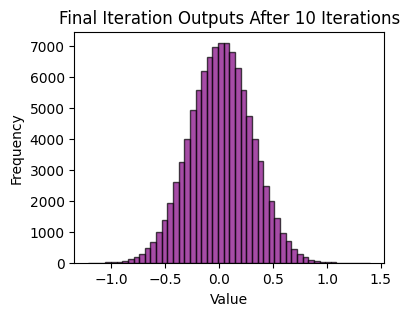

In [64]:
model.eval()

class duplicated_oneDData(Dataset):
    def __init__(self, inputs, ground_outputs):
        self.samples, self.true_samples = inputs, ground_outputs

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.true_samples[idx], dtype=torch.float32)
        )
    

def get_iterated_data(model, dataloader):
    """ This function performs an iteration of the model on the data. It then produces a duplicated dataset."""

    outputs_np = collect_model_outputs(dataloader, model) # (N,)
    
    N = outputs_np.shape[0]
    shufffled_outputs = np.random.permutation(outputs_np)  # Shuffle the outputs
    new_inputs = np.column_stack((outputs_np, shufffled_outputs))  # Shape: (N, 2)
    # Perform decimation as in your get_data function
    decimated_outputs = np.sum(new_inputs, axis=1) / np.sqrt(2)  # Shape: (N,)
    
    iterated_data = duplicated_oneDData(new_inputs, decimated_outputs)

    return iterated_data, outputs_np

# get_iterated_data(model, uniform_loader)

num_iterations = 10
current_loader = uniform_loader

print("Completely input cumulants:\n")
in_cumulants_col1, in_cumulants_col2, input_cumulants = get_input_cumulants(uniform_samples, first_col=True, sec_col=False, multidim=False)
coll1, coll2, outps = get_columns(uniform_samples)
plot_histogram(coll1, f'Initial', color='purple')

print("\nNow iterating...\n")
for i in range(num_iterations):

    iterated_data, outputs = get_iterated_data(model, current_loader) # updated dataset after a first pass
    current_loader = DataLoader(iterated_data, batch_size=64, shuffle=False)

    current_output, _, ground = get_columns(iterated_data) # ground truth for the next iteration (next loop)
    if not (outputs == current_output).all():
        print("Problem")

    print(f"Iteration {i+1}:\n")
    it_cumulant, _, _ = get_input_cumulants(iterated_data, first_col=True, sec_col=False, multidim=False) # cumulants after iteration

    # Cumulant extraction manually to check:
    it1 = cumulant_extraction(current_output)
    print("\nManually find cumulants after it1 (should be the same as the above block):")
    for k, v in it1.items():
        print(f"{k}: {v}")

    print(f"\nPredictions:")
    print(f"\nLaplace transform evolution:")
    laplace_cumulants = expected_cumulant_evolution(it_cumulant) # this is prediction of what cumulants should be after next iteration
    for k, v in laplace_cumulants.items():
        print(f"{k}: {v}")
    
    out_cumulants = cumulant_extraction(ground)
    print("\nOutput Cumulants (ground truth labels):")
    for k, v in out_cumulants.items():
        print(f"{k}: {v}")
    print("-------------------\n")
    print("\n\n")

plot_histogram(current_output, f'Final Iteration Outputs After {num_iterations} Iterations', color='purple')
# first column is just the output after n iterations